# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Instalación del paquete

# conda install pandas-datareader
# pip install pandas-datareader

In [2]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = web.DataReader("AAPL","yahoo", "2021-01-01","2022-01-01")
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,128.087082
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.670731
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.305794
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.581635
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.700058
...,...,...,...,...,...,...
2021-12-27,180.419998,177.070007,177.089996,180.330002,74919600.0,179.586868
2021-12-28,181.330002,178.529999,180.160004,179.289993,79144300.0,178.551132
2021-12-29,180.630005,178.139999,179.330002,179.380005,62348900.0,178.640778


## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [4]:
R = (data - data.shift())/data.shift()
r = np.log(data/data.shift())

In [5]:
#Nos interesamos solo en los cierres ajustados

def getClose(name, start, end) :
    return web.DataReader(name, "yahoo", start, end)["Adj Close"]

data = getClose("AAPL", "2021-01-01", "2022-01-01")
R = (data - data.shift())/data.shift()
r = np.log(data/data.shift())

<AxesSubplot:xlabel='Date'>

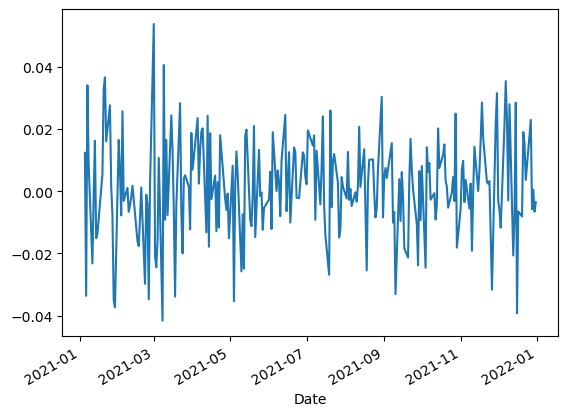

In [6]:
R.plot()

In [7]:
R.describe()

count    251.000000
mean       0.001409
std        0.015758
min       -0.041674
25%       -0.007518
50%        0.001474
75%        0.012455
max        0.053851
Name: Adj Close, dtype: float64

<AxesSubplot:>

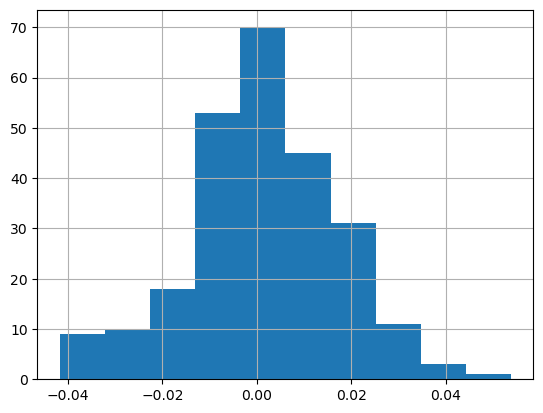

In [8]:
R.hist()

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [9]:
media_aapl = r.mean()
media_aapl

0.0012849604195632673

In [10]:
std_aapl = r.std()
std_aapl

0.01575073230894859

In [11]:
r_simulados = np.random.normal(media_aapl, std_aapl, size = (365, 5))
r_simulados

array([[ 0.00341457,  0.00772326, -0.01474986, -0.0176889 ,  0.00767159],
       [ 0.00014823,  0.00081901, -0.0098088 , -0.01291767,  0.00250549],
       [-0.01701974,  0.02077676, -0.00131876, -0.0068435 ,  0.01122813],
       ...,
       [-0.00712102, -0.00615352,  0.00797561,  0.01363745,  0.0178105 ],
       [-0.0199103 , -0.00570891,  0.02116683,  0.00596336, -0.00052596],
       [ 0.01983567, -0.01280539,  0.00976763,  0.0055771 ,  0.00188216]])

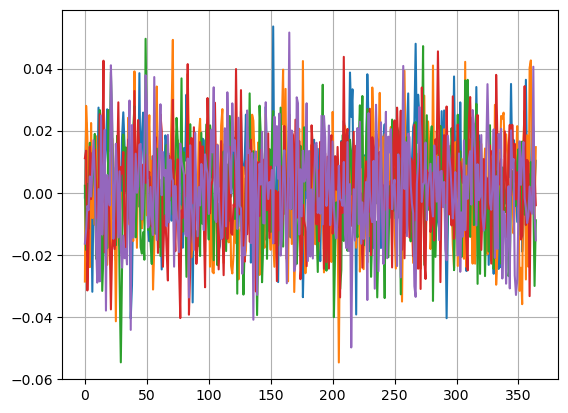

In [12]:
r_simulados = np.random.normal(media_aapl, std_aapl, size = (365, 5))
r_simulados

plt.figure()
plt.plot(r_simulados)
plt.grid()

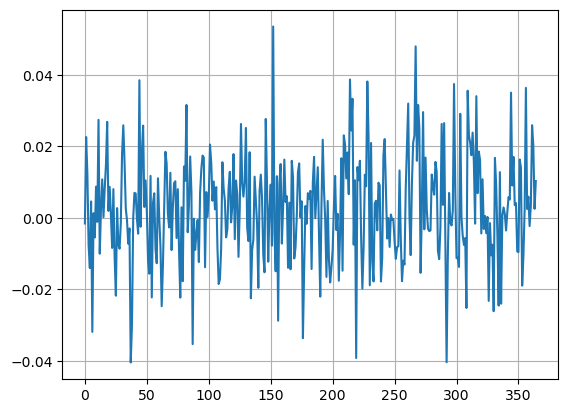

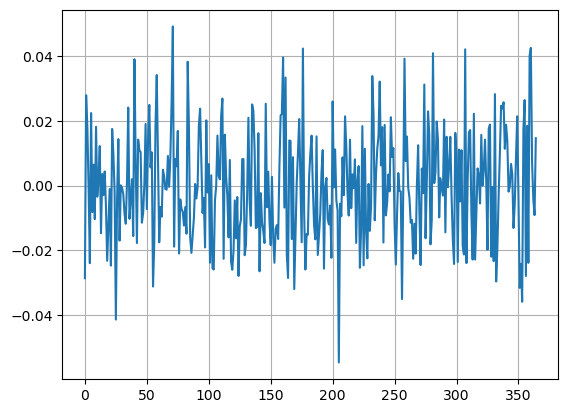

In [13]:
plt.figure()
plt.plot(r_simulados[:, 0])
plt.grid()

plt.figure()
plt.plot(r_simulados[:, 1])
plt.grid()

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos desde 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [14]:
def sim_r(media, std, inicio, dias, N):
    r = np.random.normal(media, std, size=(dias, N)) #Simula tantos días N veces de una distribuvi+on normal
    fechas = pd.date_range(inicio, periods=dias)
    return pd.DataFrame(index=fechas, data=r)

In [15]:
sim_r(0, 1, "2022-10-27", 7, 5)

,0,1,2,3,4
2022-10-27,1.826574,0.041034,-1.116916,-2.436223,-1.229054
2022-10-28,-0.114504,-1.182217,-0.733176,0.430811,0.586610
2022-10-29,-0.354872,-0.446237,0.438720,1.841126,2.093458
2022-10-30,-1.374344,-0.862689,-0.171633,1.557082,-0.523218
2022-10-31,-1.179764,0.742075,0.208908,-2.156580,1.017199
2022-11-01,0.971472,0.266254,-1.641327,0.690617,0.446118
2022-11-02,-0.595503,0.422197,0.092441,-0.187073,0.028420


In [16]:
pd.date_range?

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [17]:
data = getClose("META", "2021-01-01", "today")
data

Date
2021-01-04    268.940002
2021-01-05    270.970001
2021-01-06    263.309998
2021-01-07    268.739990
2021-01-08    267.570007
                 ...    
2022-10-21    130.009995
2022-10-24    129.720001
2022-10-25    137.509995
2022-10-26    129.820007
2022-10-27     97.940002
Name: Adj Close, Length: 459, dtype: float64

In [18]:
r= np.log(data/data.shift()).dropna()

<AxesSubplot:>

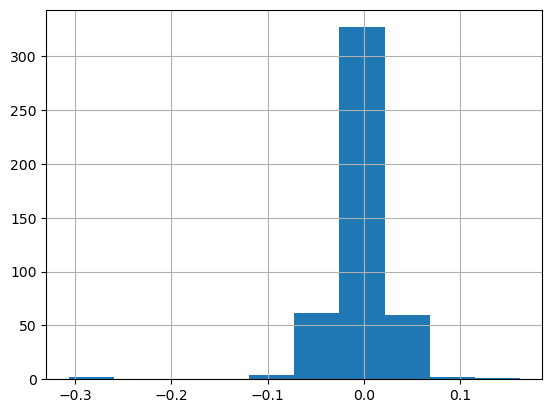

In [19]:
r.hist()

In [20]:
media_meta= r.mean()
std_meta = r.std()
media_meta, std_meta

(-0.00220553110103028, 0.03265773422106914)

In [21]:
r_simulados = sim_r(media_meta, std_meta, "2022-10-28", 365, 1000)
r_simulados.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2022-10-28,-0.010205,-0.047427,-0.026746,0.083212,-0.012757,-0.051285,-0.002598,-0.050971,-0.046000,-0.022982,...,-0.027577,0.000182,0.000019,-0.042742,0.040064,0.003289,0.005656,0.012357,-0.048917,-0.034440
2022-10-29,0.027674,0.001060,-0.015857,-0.037562,0.002366,0.014353,0.045873,0.017930,-0.019410,-0.020912,...,-0.003555,-0.002020,-0.016970,-0.057414,0.044338,-0.000518,-0.101191,0.021485,-0.042522,-0.028103
2022-10-30,-0.025743,-0.038191,-0.100560,0.002069,0.037772,0.031262,0.024023,-0.000326,-0.008515,0.023083,...,-0.028777,-0.018300,0.014456,-0.056229,0.031955,-0.044650,0.009808,-0.032445,0.021439,0.017135
2022-10-31,0.036303,-0.039709,-0.006409,0.004275,-0.040788,0.029558,-0.035889,-0.015129,-0.003147,0.009259,...,0.038391,0.010069,-0.024793,-0.001490,-0.027180,-0.000741,0.031502,0.016368,0.012197,-0.043651
2022-11-01,-0.014354,-0.029226,0.022335,-0.019672,-0.004026,0.001500,0.014813,-0.033966,0.019378,-0.028549,...,-0.051712,-0.040370,-0.019806,-0.029808,-0.004824,0.036787,0.004023,-0.021037,-0.057161,0.015723


In [22]:
data[-1]

97.94000244140625

In [23]:
(1 + r_simulados).cumprod().head(22)*data[-1]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2022-10-28,96.940564,93.295008,95.320456,106.089826,96.690542,92.917130,97.685522,92.947894,93.434749,95.689192,...,95.239130,97.957820,97.941891,93.753849,101.863868,98.262143,98.493992,99.150216,93.149047,94.566913
2022-10-29,99.623334,93.393868,93.808952,102.104904,96.919317,94.250764,102.166655,94.614465,91.621189,93.688102,...,94.900549,97.759921,96.279816,88.371022,106.380323,98.211252,88.527311,101.280440,89.188162,91.909283
2022-10-30,97.058700,89.827019,84.375532,102.316143,100.580154,97.197227,104.620956,94.583627,90.841047,95.850706,...,92.169614,95.970897,97.671638,83.402005,109.779722,93.826141,89.395574,97.994436,91.100303,93.484173
2022-10-31,100.582258,86.260096,83.834806,102.753556,96.477717,100.070170,100.866178,93.152636,90.555214,96.738228,...,95.708062,96.937267,95.250020,83.277772,106.795875,93.756643,92.211757,99.598436,92.211482,89.403472
2022-11-01,99.138458,83.739080,85.707256,100.732225,96.089297,100.220263,102.360348,89.988653,92.309982,93.976407,...,90.758764,93.023898,93.363475,80.795408,106.280689,97.205711,92.582684,97.503146,86.940574,90.809178
2022-11-02,100.844120,82.325241,81.781081,100.561765,96.028790,97.349612,102.438592,86.901728,99.825264,91.519142,...,91.232251,91.556238,95.530954,86.239923,102.726208,96.059787,95.710794,96.513919,84.682243,89.734461
2022-11-03,106.575406,84.303558,86.085446,99.626328,95.537595,99.535029,103.301384,88.491767,102.116295,91.622963,...,90.380150,93.421568,88.472878,87.186206,101.805561,92.654982,98.402502,100.017516,82.024761,86.417439
2022-11-04,108.048662,82.116979,84.891306,101.518055,101.315279,107.906027,98.654612,90.054218,101.745228,92.613270,...,93.984218,95.956135,88.086789,91.412359,104.024167,92.099312,96.459964,101.949133,78.706541,80.552994
2022-11-05,107.400835,83.014258,83.824227,101.480327,99.733227,106.478584,99.258369,89.985778,102.231398,89.726038,...,95.965976,93.255807,88.740263,93.058767,106.290503,94.010948,97.930791,100.343208,77.082729,78.384942
2022-11-06,106.799345,86.375487,83.540495,108.090260,99.721427,108.355556,98.609235,86.300088,104.476397,85.087564,...,100.078409,92.634910,82.487036,98.884420,105.484090,86.612650,93.338280,93.213375,75.675019,76.905280


## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [24]:
valor_deseado = data[-1]*1.05
valor_deseado

102.83700256347657

In [25]:
precios_simulados = (1 + r_simulados).cumprod()*data[-1]
sobrepasa_el_deseado = precios_simulados >= valor_deseado
probabilidad = sobrepasa_el_deseado.mean(axis=1)

<AxesSubplot:>

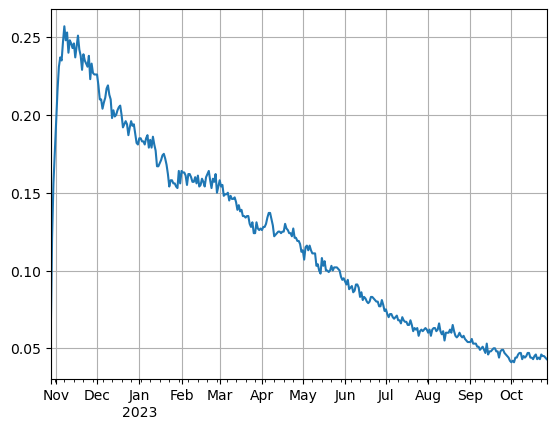

In [26]:
probabilidad.plot(grid=True)

<AxesSubplot:>

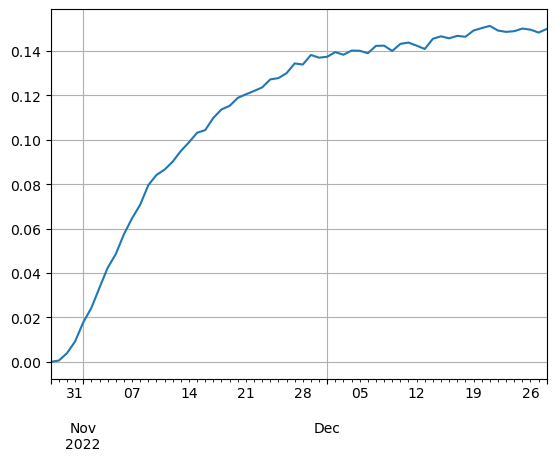

In [27]:
data = getClose("AAPL", "2022-01-01", "today")
r_aapl= np.log(data/data.shift()).dropna()
rs_aapl = sim_r(r_aapl.mean(), r_aapl.std(), "2022-10-28", 62, 10000)
vs_aapl = (1 + rs_aapl).cumprod()*data[-1]

valor_deseado = data[-1]*1.10
Bs_aapl = vs_aapl>= valor_deseado
ps_aapl = Bs_aapl.mean(axis=1)
ps_aapl.plot(grid=True)

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.